In [77]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix

In [78]:
TARGET_COL = "coarse_genre_top"
OTHERS = ["genre_top"]
TEST_SIZE = 0.2
N_SPLITS = 5

## Load datasets

In [79]:
df_train = pd.read_csv("../DataBase/processed/train_data.csv")
print(df_train.shape)

df_test = pd.read_csv("../DataBase/processed/test_data.csv")
print(df_test.shape)

(5493, 41)
(1374, 41)


## Data preprocessing

In [80]:
GENRE_MAPPING = {
    "Energique": ["Electronic", "Experimental", "Pop", "Hip-Hop"],
    "Rock": ["Rock", "Blues", "Instrumental"],
    "Acoustic": ["Classical", "Jazz"],
    "Traditionnal": ["Old-Time / Historic", "Folk", "Country", "International"]
}

def coarse_genre_top(genre_top):
    for genre_top_coarse in GENRE_MAPPING:
        if genre_top in GENRE_MAPPING[genre_top_coarse]:
            return genre_top_coarse
    return None

df_train["coarse_genre_top"] = df_train["genre_top"].apply(coarse_genre_top)
df_test["coarse_genre_top"] = df_test["genre_top"].apply(coarse_genre_top)

In [81]:
df_train = df_train[df_train[TARGET_COL].notna()].dropna().copy()
print(df_train.shape)

df_test = df_test[df_test[TARGET_COL].notna()].dropna().copy()
print(df_test.shape)

(5493, 42)
(1374, 42)


In [82]:
label_encoder = LabelEncoder()
df_train[TARGET_COL] = label_encoder.fit_transform(df_train[TARGET_COL])
df_test[TARGET_COL] = label_encoder.transform(df_test[TARGET_COL])

mapping = dict(zip(label_encoder.classes_, np.arange(len(label_encoder.classes_))))
print(mapping)

{'Acoustic': np.int64(0), 'Energique': np.int64(1), 'Rock': np.int64(2), 'Traditionnal': np.int64(3)}


In [83]:
X_train, X_test = df_train.drop(columns=[TARGET_COL] + OTHERS), df_test.drop(columns=[TARGET_COL]+OTHERS)
y_train, y_test = df_train[TARGET_COL], df_test[TARGET_COL]

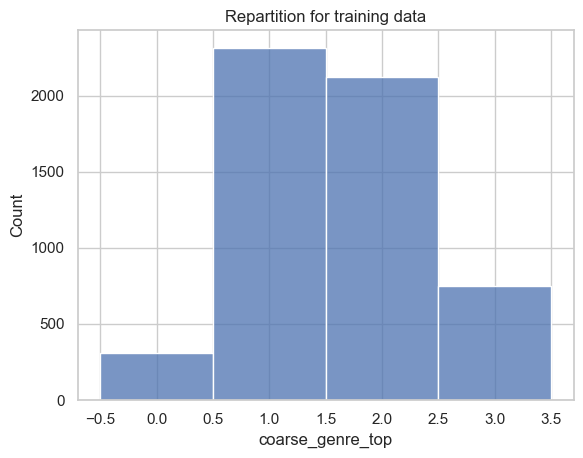

In [84]:
ax = sns.histplot(y_train, discrete=True)
ax.set_title("Repartition for training data")
plt.show()

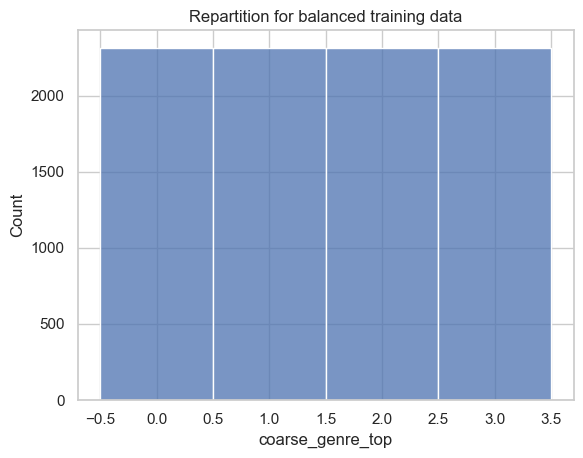

In [85]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

ax = sns.histplot(y_train_balanced, discrete=True)
ax.set_title("Repartition for balanced training data")
plt.show()

## Model training

In [86]:
k_fold = KFold(N_SPLITS)

### Logistic regression

#### Training with basic hyperparams

In [87]:
logistic_regression = LogisticRegression(random_state=42)

scores = cross_validate(logistic_regression, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergenc

Accuracy: 0.646 +- 0.018


c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
logistic_regression.fit(X_train_balanced, y_train_balanced)
predictions = logistic_regression.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_logistic_regression = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.22      0.60      0.33        77
           1       0.74      0.63      0.68       579
           2       0.66      0.54      0.59       531
           3       0.42      0.53      0.47       187

    accuracy                           0.58      1374
   macro avg       0.51      0.58      0.52      1374
weighted avg       0.64      0.58      0.60      1374



c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Training with hyperparams optimization

In [89]:
PARAM_GRID = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

In [90]:
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Lesli\Documents\Cours\IMT\3A\Fondamentals of Machine Learning\Supervised_Challenge\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.01, 0.1, ...], 'penalty': ['l2'], 'solver': ['lbfgs']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [91]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_logistic_regression_optimization = report_dict['accuracy']

Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score (based on training data): 0.4204
              precision    recall  f1-score   support

           0       0.22      0.58      0.32        77
           1       0.73      0.64      0.68       579
           2       0.66      0.53      0.59       531
           3       0.42      0.54      0.47       187

    accuracy                           0.58      1374
   macro avg       0.51      0.57      0.52      1374
weighted avg       0.63      0.58      0.60      1374



### KNN

#### Training with basic hyperparams

In [92]:
knn = KNeighborsClassifier()

scores = cross_validate(knn, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.663 +- 0.012


In [93]:
knn.fit(X_train_balanced, y_train_balanced)
predictions = knn.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_knn = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.28      0.64      0.39        77
           1       0.75      0.64      0.69       579
           2       0.70      0.61      0.65       531
           3       0.49      0.64      0.56       187

    accuracy                           0.63      1374
   macro avg       0.55      0.63      0.57      1374
weighted avg       0.67      0.63      0.64      1374



#### Training with hyperparams

In [94]:
PARAM_GRID = {
    'n_neighbors': [3, 5, 7, 9, 11, 15], 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [95]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,3


In [96]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_knn_optimization = report_dict['accuracy']

Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best CV score (based on training data): 0.7915
              precision    recall  f1-score   support

           0       0.39      0.68      0.49        77
           1       0.78      0.65      0.71       579
           2       0.70      0.68      0.69       531
           3       0.52      0.68      0.59       187

    accuracy                           0.67      1374
   macro avg       0.60      0.67      0.62      1374
weighted avg       0.69      0.67      0.67      1374



### SVC

#### Traiining with basic hyperparams

In [97]:
svc = SVC(random_state=42)

scores = cross_validate(svc, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.569 +- 0.022


In [98]:
svc.fit(X_train_balanced, y_train_balanced)
predictions = svc.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_svc = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.18      0.31      0.23        77
           1       0.72      0.60      0.66       579
           2       0.64      0.54      0.58       531
           3       0.33      0.55      0.42       187

    accuracy                           0.55      1374
   macro avg       0.47      0.50      0.47      1374
weighted avg       0.61      0.55      0.57      1374



#### Training with hyperparams optimization

In [ ]:
# PARAM_GRID = {
#     'C': [0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 0.1]
# }

In [ ]:
# grid_search = GridSearchCV(
#     estimator=SVC(random_state=42),
#     param_grid=PARAM_GRID,
#     cv= KFold(n_splits=N_SPLITS),
#     scoring="accuracy",
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
# print(f"Best params: {grid_search.best_params_}")
# print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
# predictions = grid_search.best_estimator_.predict(X_test)
# print(classification_report(y_test, predictions, zero_division=1))
# report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
# accuracy_svc_optimization = report_dict['accuracy']

### Random Forest

#### Training with basic hyperparams

In [101]:
# with spectral and echonest features
random_forest = RandomForestClassifier(random_state=42)

scores = cross_validate(random_forest, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.772 +- 0.01


In [102]:
random_forest.fit(X_train_balanced, y_train_balanced)
predictions = random_forest.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_random_forest = report_dict['accuracy']

              precision    recall  f1-score   support

           0       0.66      0.71      0.69        77
           1       0.83      0.83      0.83       579
           2       0.81      0.76      0.78       531
           3       0.71      0.78      0.74       187

    accuracy                           0.79      1374
   macro avg       0.75      0.77      0.76      1374
weighted avg       0.79      0.79      0.79      1374



#### Training with hyperparams optimization

In [103]:
PARAM_GRID = {
    "n_estimators": [100, 300, 500],
    "max_depth": [10, 20, None], # None permet aux arbres de se développer pleinement
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [104]:
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=PARAM_GRID,
    cv= KFold(n_splits=N_SPLITS),
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 300, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,KFold(n_split...shuffle=False)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [105]:
print(f"Best params: {grid_search.best_params_}")
print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
predictions = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_random_forest_optimization = report_dict['accuracy']

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV score (based on training data): 0.8024
              precision    recall  f1-score   support

           0       0.68      0.69      0.68        77
           1       0.83      0.83      0.83       579
           2       0.80      0.77      0.78       531
           3       0.70      0.79      0.74       187

    accuracy                           0.79      1374
   macro avg       0.75      0.77      0.76      1374
weighted avg       0.79      0.79      0.79      1374



### XGBoost

#### Training with basic hyperparams

In [106]:
# with spectral and echonest features
xgb = XGBClassifier(random_state=42)

scores = cross_validate(xgb, X_train, y_train, cv=k_fold)["test_score"]
print("Accuracy:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))

Accuracy: 0.829 +- 0.014


In [107]:
xgb.fit(X_train_balanced, y_train_balanced)
predictions = xgb.predict(X_test)
print(classification_report(y_test, predictions, zero_division=1))
report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
accuracy_xgb = report_dict['accuracy']
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77        77
           1       0.86      0.84      0.85       579
           2       0.83      0.82      0.83       531
           3       0.73      0.79      0.76       187

    accuracy                           0.82      1374
   macro avg       0.80      0.80      0.80      1374
weighted avg       0.83      0.82      0.82      1374

[[ 58   4   5  10]
 [  6 488  64  21]
 [  8  61 438  24]
 [  1  15  23 148]]


#### Training with hyperparams optimization

In [108]:
PARAM_GRID = {
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

In [ ]:
# grid_search = GridSearchCV(
#     estimator=XGBClassifier(random_state=42),
#     param_grid=PARAM_GRID,
#     cv= KFold(n_splits=N_SPLITS),
#     scoring="accuracy",
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train_balanced, y_train_balanced)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

In [ ]:
# print(f"Best params: {grid_search.best_params_}")
# print(f"Best CV score (based on training data): {grid_search.best_score_:.4f}")
# predictions = grid_search.best_estimator_.predict(X_test)
# print(classification_report(y_test, predictions, zero_division=1))
# report_dict = classification_report(y_test, predictions, zero_division=1, output_dict=True)
# accuracy_xgb_optimization = report_dict['accuracy']

Best params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'subsample': 0.7}
Best CV score (based on training data): 0.8817
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        88
           1       0.84      0.84      0.84       585
           2       0.82      0.81      0.81       513
           3       0.78      0.78      0.78       188

    accuracy                           0.82      1374
   macro avg       0.80      0.82      0.81      1374
weighted avg       0.82      0.82      0.82      1374



## Comparaison

In [110]:
models = ['Logistic Reg', 'KNN', 'SVC', 'Random Forest', 'XGBoost','Logistic Reg', 'KNN', 'Random Forest' ]

accuracies = [
    accuracy_logistic_regression, accuracy_knn, accuracy_svc, accuracy_random_forest, accuracy_xgb,
    accuracy_logistic_regression_optimization, accuracy_knn_optimization, 
    accuracy_random_forest_optimization
]

# accuracies = [
#     accuracy_logistic_regression, accuracy_knn, accuracy_svc, accuracy_random_forest, accuracy_xgb,
#     accuracy_logistic_regression_optimization, accuracy_knn_optimization
# ]

config = ['Standard', 'Standard','Standard','Standard','Standard', 
                'Optimization', 'Optimization', 'Optimization']

results = {
    'Modèle': models,
    'Accuracy': accuracies,
    'Configuration': config
}

df_comparaison = pd.DataFrame(results)

print(df_comparaison)

          Modèle  Accuracy Configuration
0   Logistic Reg  0.582242      Standard
1            KNN  0.626638      Standard
2            SVC  0.554585      Standard
3  Random Forest  0.791849      Standard
4        XGBoost  0.823872      Standard
5   Logistic Reg  0.582242  Optimization
6            KNN  0.666667  Optimization
7  Random Forest  0.790393  Optimization


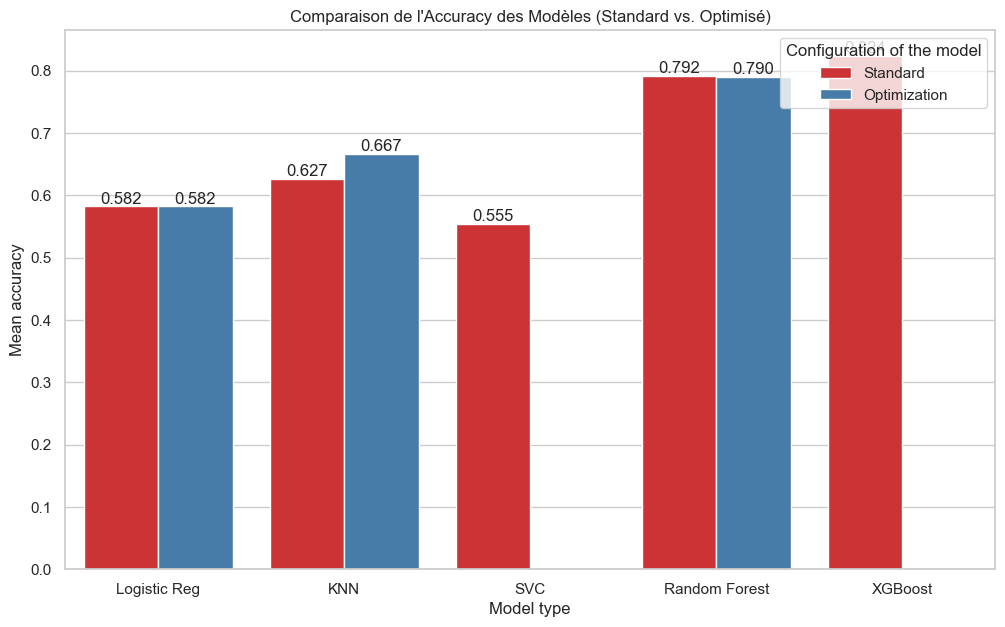

In [111]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

bar_plot = sns.barplot(
    x='Modèle', 
    y='Accuracy', 
    hue='Configuration', 
    data=df_comparaison, 
    palette='Set1'
)


plt.title('Comparaison de l\'Accuracy des Modèles (Standard vs. Optimisé)')
plt.ylabel('Mean accuracy')
plt.xlabel('Model type')


plt.legend(title='Configuration of the model', loc='upper right')

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.3f')

plt.show()